In [1]:
# Nate Brunacini, nbrunaci@u.rochester.edu
# Supervisor: Kelly A. Douglass
# To switch between DR15 and DR17, change the config.setRelease line and any uses of drpall (v2_4_3 for DR15 and v3_1_1 for 
# DR17). The v2_4_3 file has "-Copy1" at the end of its name so it is not accidentally used by any other notebook. Also change 
# figure titles and file names in savefig lines (these can both be changed by the variable named "version."

# NOTE: IVAR FUNCTIONS ARE NOT UPDATED

In [1]:
# Import packages

import marvin
from marvin.tools.maps import Maps
from marvin.tools import Image
from marvin import config
config.setRelease('DR17')

import numpy as np
import numpy.ma as ma
from numpy import log10, pi

import matplotlib.pyplot as plt

from astropy.io import fits
import astropy.constants as const

import math

import pyneb as pn

/home/nbrunaci/.local/lib/python3.8/site-packages/marvin/core/exceptions.py:50: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  warnings.warn('cannot initiate Sentry error reporting: {0}.'.format(str(ee)),
[INFO]: No release version set. Setting default to DR17
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


In [2]:
# Takes in plate and IFU numbers of a galaxy, returns nested dictionary of each relevent emission line's flux and inverse variance in masked arrays
# Called by addDiagnostics_Pilyugin function
# Could probably by merged with the addDiagnostics function
def getDataMaps_Pilyugin(plateifu):
    maps = Maps(plateifu)
    
    # Obtaining redshift data from drpall fits file
    with fits.open('drpall-v3_1_1.fits', memmap=True) as drpall:
        tbdata = drpall[1].data
        ind = np.where(tbdata['plateifu'] == plateifu)
        redshift = tbdata['nsa_z'][ind][0]# This [0] is here because each z value seems to be in its own array for some reason
    
    # Observed emission lines
    HbF_map = maps["emline_gflux_hb_4862"]
    OII_map = maps["emline_gflux_oii_3727"]
    OIII_map = maps["emline_gflux_oiii_5008"]
    OIII2_map = maps["emline_gflux_oiii_4960"]
    NII_map = maps["emline_gflux_nii_6585"]
    NII2_map = maps["emline_gflux_nii_6549"]
    HaF_map = maps["emline_gflux_ha_6564"]
    OII2_map = maps["emline_gflux_oii_3729"]
    observed = [HbF_map,OII_map,OII2_map,OIII_map,OIII2_map,NII_map,NII2_map,HaF_map,]# Array of observed emission lines
    names = ['HbF','OII','OII2','OIII','OIII2','NII','NII2','HaF']# Array of names of observed emission lines
    
#     print('HbF:',HbF_map.data[52,29])
#     print('OII:',OII_map.data[52,29])
#     print('OIII:',OIII_map.data[52,29])
#     print('OIII2:',OIII2_map.data[52,29])
#     print('NII:',NII_map.data[52,29])
#     print('NII2:',NII2_map.data[52,29])
#     print('Test OII2:',OII2_map.data[52,29])
    
    # Array of masked flux arrays for observed emission lines
    observed_m = []
    for line in observed:
        observed_m.append(line.masked)
    
    # Array of masked inverse variance arrays for observed emission lines
    observed_ivar_m = []
    for line in observed:
        observed_ivar_m.append(ma.array(line.ivar,mask=line.mask))
    
    return{
        names[0]: {'flux': observed_m[0], 'ivar': observed_ivar_m[0]},
        names[1]: {'flux': observed_m[1], 'ivar': observed_ivar_m[1]},
        names[2]: {'flux': observed_m[2], 'ivar': observed_ivar_m[2]},
        names[3]: {'flux': observed_m[3], 'ivar': observed_ivar_m[3]},
        names[4]: {'flux': observed_m[4], 'ivar': observed_ivar_m[4]},
        names[5]: {'flux': observed_m[5], 'ivar': observed_ivar_m[5]},
        names[6]: {'flux': observed_m[6], 'ivar': observed_ivar_m[6]},
        names[7]: {'flux': observed_m[7], 'ivar': observed_ivar_m[7]},
        'z': redshift,# This did not end up being used
        'wavelength': [4862,3727,5008,4960,6585,6549,6564,3729]# Wavelength of each line
    }

In [3]:
# TODO: IMPLEMENT THIS FUNCTION
def getDustCorrectedIvars(observed):
    return  {
        'HbF':0,# THESE ZEROS ARE PLACEHOLDERS
        'OII':0,
        'OII2':0,
        'OIII':0,
        'OIII2':0,
        'NII':0,
        'NII2':0,
        'HaF':0
    }

In [4]:
# Takes in output from getDataMaps_Pilyugin, returns those maps corrected for dust extinction
def dustCorrect(datamaps):
    RC = pn.RedCorr(law='CCM89')
    
    # Calculate the observed Ha/Hb flux ratio
    HaHb_obs = datamaps['HaF']['flux'] / datamaps['HbF']['flux']
    
    # Calculate correction coefficient based on theoretical Ha/Hb ratio
    RC.setCorr(HaHb_obs/2.86, 6563., 4861.)
    
    # Error propagation
    dcIvars = getDustCorrectedIvars(datamaps)
    
    # De-redden emission line
    for index,line in enumerate(datamaps):
        if index<len(datamaps)-2:# To exclude the z and wavelength values
            datamaps[line]['flux'] = datamaps[line]['flux'] * RC.getCorrHb(datamaps['wavelength'][index])
            # Updating error values
            datamaps[line]['ivar'] = dcIvars[line]
    
    return datamaps

In [5]:
# Takes in output from getDataMaps_Pilyugin function, returns dictionary of inverse variance arrays for calculated abundance diagnostics
# Called by addDiagnostics_Pilyugin function
def getDiagnosticIvars_Pilyugin(observed):
    
    # Fluxes
    b = observed['HbF']['flux']
    oii = observed['OII']['flux']
    oiii = observed['OIII']['flux']
    oiii2 = observed['OIII2']['flux']
    nii = observed['NII']['flux']
    nii2 = observed['NII2']['flux']
    
    # Inverse variances
    ib = observed['HbF']['ivar']
    ioii = observed['OII']['ivar']
    ioiii = observed['OIII']['ivar']
    ioiii2 = observed['OIII2']['ivar']
    inii = observed['NII']['ivar']
    inii2 = observed['NII2']['ivar']
    
    # R2 ivar calculations:
    # R2 = f(o,b) where o=OII, b=HbF
    # f = o/b
    # ivar_f = 1.0 / ( (df/do)**2/ivar_o + (df/db)**2/ivar_b ) where d means partial derivative
    # Evaluated: ivar_f = 1.0 / ( 1.0/(b**2*ivar_o) + o**2/(b**4*ivar_b) )
    R2_ivar_m = 1.0 / (1.0/(b**2*ioii) + oii**2/(b**4*ib))
    
    # N2 ivar calculations:
    # N2 = f(n,n2,b) where n=NII, n2=NII2, b=HbF
    # f = (n+n2)/b
    # ivar_f = 1.0 / ( (df/dn)**2/ivar_n + (df/dn2)**2/ivar_n2 + (df/db)**2/ivar_b ) where d means partial derivative
    # Evaluated: ivar_f = 1.0 / ( 1.0/(b**2*ivar_n) + 1.0/(b**2*ivar_n2) + (-(n+n2)/b**2)**2/ivar_b )
    N2_ivar_m = 1.0 / (1.0/(b**2*inii) + 1.0/(b**2*inii2) + (-(nii+nii2)/b**2)**2/ib)
    
    # R3 ivar calculations:
    # R3 = f(o,o2,b) where o=OIII, o2=OIII2, b=HbF
    # f = (o+o2)/b
    # ivar_f = 1.0 / ( (df/do)**2/ivar_o + (df/do2)**2/ivar_o2 + (df/db)**2/ivar_b ) where d means partial derivative
    # Evaluated: ivar_f = 1.0 / ( 1.0/(b**2*ivar_o) + 1.0/(b**2*ivar_o2) + (-(o+o2)/b**2)**2/ivar_b )
    R3_ivar_m = 1.0 / (1.0/(b**2*ioiii) + 1.0/(b**2*ioiii2) + (-(oiii+oiii2)/b**2)**2/ib)
    
    return {
        'R2':R2_ivar_m,
        'N2':N2_ivar_m,
        'R3':R3_ivar_m
    }

In [6]:
# Takes in plate and IFU numbers of a galaxy, returns dictionary of observed lines from getDataMaps_Pilyugin function 
# (corrected for dust extinction) plus calculated abundance diagnostics
def addDiagnostics_Pilyugin(plateifu):
    observed = dustCorrect(getDataMaps_Pilyugin(plateifu))
    
#     fluxes = [flux for flux in observed.items()]# Creates array of the same maps as accessed below but lacks names
    HbF_flux_m = observed['HbF']['flux']
    OII_flux_m = observed['OII']['flux']
    OII2_flux_m = observed['OII2']['flux']
    OIII_flux_m = observed['OIII']['flux']
    OIII2_flux_m = observed['OIII2']['flux']
    NII_flux_m = observed['NII']['flux']
    NII2_flux_m = observed['NII2']['flux']
    HaF_flux_m = observed['HaF']['flux']
    
#     print(OII_flux_m[52,29])
#     print(OII2_flux_m[52,29])
    
    # Flux for calculated abundance diagnostics (masked)
    R2_flux_m = (OII_flux_m + OII2_flux_m) / HbF_flux_m
#     print(R2_flux_m[52,29])
    N2_flux_m = (NII_flux_m + NII2_flux_m) / HbF_flux_m
    R3_flux_m = (OIII_flux_m + OIII2_flux_m) / HbF_flux_m
    
    # Inverse variance for calculated abuance diagnostics (masked)
    dIvars = getDiagnosticIvars_Pilyugin(observed)
    
    diagnostics = {
        'R2': {'flux': R2_flux_m, 'ivar': dIvars['R2']},
        'N2': {'flux': N2_flux_m, 'ivar': dIvars['N2']},
        'R3': {'flux': R3_flux_m, 'ivar': dIvars['R3']}
    }
#     return observed | diagnostics# This is not supported in Python 3 (anaconda3 2020.11)
    return {**observed, **diagnostics}

In [7]:
# Takes in output from addDiagnostics function, returns dictionary of inverse variance arrays for each metallicity method
# Called by findMetallicities function
def getMetallicityIvars_Pilyugin(eqtype,r3,r2,n2,ir3,ir2,in2):
    
    #NOTE: ma.log is natural log (ln)
    
    # Constants
    if eqtype == 'lower':
        A = 7.932
        B = 0.944
        C = 0.695
        D = 0.970
        E = -0.291
        F = -0.019
    else:
        A = 8.589
        B = 0.022
        C = 0.399
        D = -0.137
        E = 0.164
        F = 0.589
    ln10 = ma.log(10)
    
    # R metallicity ivar calculations:
    # R_metallicity = f(r3,r2,n2)
    # f = A + B * ma.log10(r3/r2) + C * ma.log10(n2) + (D + E * ma.log10(r3/r2) + F * ma.log10(n2)) * ma.log10(r2)
    dfdr3 = (E*ma.log(r2)+B*ln10)/(r3*ln10**2)
    dfdr2 = -(E*ma.log(r2)-E*ma.log(r3/r2)-F*ma.log(n2)-D*ln10+B*ln10)/(r2*ln10**2)
    dfdn2 = (F*ma.log(r2)+C*ln10)/(n2*ln10**2)
    R_metallicity_ivar = 1.0 / ( (dfdr3)**2/ir3 + (dfdr2)**2/ir2 + (dfdn2)**2/in2 )
    
    return R_metallicity_ivar

In [8]:
# Takes in output from addDiagnostics_Pilyugin function, calculates and returns metallicities calculated using equations from Pilyugin and Grebel 2016 and their inverse variances
# dataMaps must be a dictionary of the masked flux and ivar of each emission line, as is output by addDiagnostics_Pilyugin
def findMetallicities_Pilyugin(dataMaps):
    
    R3 = dataMaps['R3']['flux']
    R2 = dataMaps['R2']['flux']
    N2 = dataMaps['N2']['flux']
    ratio = R3/R2
    R3_ivar = dataMaps['R3']['ivar']
    R2_ivar = dataMaps['R2']['ivar']
    N2_ivar = dataMaps['N2']['ivar']
    
    R_metallicity = np.empty_like(N2)
    R_ivar = np.empty_like(N2)
    
    # Generate masks
    HbF_mask = (dataMaps['HbF']['flux']*np.sqrt(dataMaps['HbF']['ivar']) < 3) + dataMaps['HbF']['flux'].mask
    OII_mask = (dataMaps['OII']['flux']*np.sqrt(dataMaps['OII']['ivar']) < 3) + dataMaps['OII']['flux'].mask
    OII2_mask = (dataMaps['OII2']['flux']*np.sqrt(dataMaps['OII2']['ivar']) < 3) + dataMaps['OII2']['flux'].mask
    OIII_mask = (dataMaps['OIII']['flux']*np.sqrt(dataMaps['OIII']['ivar']) < 3) + dataMaps['OIII']['flux'].mask
    OIII2_mask = (dataMaps['OIII2']['flux']*np.sqrt(dataMaps['OIII2']['ivar']) < 3) + dataMaps['OIII2']['flux'].mask
    NII_mask = (dataMaps['NII']['flux']*np.sqrt(dataMaps['NII']['ivar']) < 3) + dataMaps['NII']['flux'].mask
    NII2_mask = (dataMaps['NII2']['flux']*np.sqrt(dataMaps['NII2']['ivar']) < 3) + dataMaps['NII2']['flux'].mask
    HaF_mask = (dataMaps['HaF']['flux']*np.sqrt(dataMaps['HaF']['ivar']) < 5) + dataMaps['HaF']['flux'].mask
    
    R_metallicity.mask = HbF_mask + OII_mask + OIII_mask + OIII2_mask + NII_mask + NII2_mask + OII2_mask
    R_ivar.mask = R_metallicity.mask
    
    for i in range(0,len(R_metallicity)):
        for j in range(0,len(R_metallicity[i])):
            
            R3val = R3[i][j]
            R2val = R2[i][j]
            N2val = N2[i][j]
            logratio = ma.log10(ratio[i][j])
            
            if ma.log10(N2[i][j]) < -0.6:
                # RL metallicity equation (Pilyugin et al. Eq. 5)
                R_metallicity[i][j] = 7.932 + 0.944 * logratio + 0.695 * ma.log10(N2val) + (0.970 - 0.291 * logratio - 0.019 * ma.log10(N2val)) * ma.log10(R2val)
                R_ivar[i][j] = getMetallicityIvars_Pilyugin('lower',R3val,R2val,N2val,R3_ivar[i][j],R2_ivar[i][j],N2_ivar[i][j])
            else:
                # RU metallicity equation (Pilyugin et al. Eq. 4)
                R_metallicity[i][j] = 8.589 + 0.022 * logratio + 0.399 * ma.log10(N2val) + (-0.137 + 0.164 * logratio + 0.589 * ma.log10(N2val)) * ma.log10(R2val)
                R_ivar[i][j] = getMetallicityIvars_Pilyugin('upper',R3val,R2val,N2val,R3_ivar[i][j],R2_ivar[i][j],N2_ivar[i][j])
            
#             # Mask any spaxels with a HaF signal-to-noise ratio of less than 5
#             if dataMaps['HaF']['flux'][i][j] * math.sqrt(dataMaps['HaF']['ivar'][i][j]) < 5:
#                 R_metallicity.mask[i][j] = True
#                 R_ivar.mask[i][j] = True
    
    return{
        'R':{'metallicity': R_metallicity, 'ivar': R_ivar}
    }

In [9]:
# Wrapper function for the above functions. Calculates the metallicity values of the spaxels in the galaxy with 
# the input plateifu using the Pilyugin method
def calcMetallicities(plateifu):
    objmaps_R = addDiagnostics_Pilyugin(plateifu)
    results_R = findMetallicities_Pilyugin(objmaps_R)
    return results_R

In [10]:
results_R = calcMetallicities('10001-12701')#'9871-12702'

version = 'DR17'

[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)
[WARNING]: divide by zero encountered in double_scalars (RuntimeWarning)
[WARNING]: invalid value encountered in double_scalars (RuntimeWarning)


In [89]:
print(results_R['R']['metallicity'][52,29])

7.316141446159772


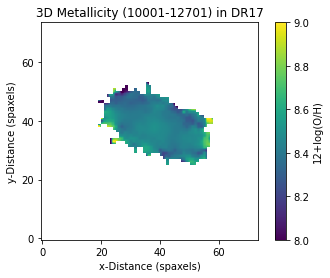

In [13]:
plt.imshow(results_R['R']['metallicity'],origin='lower',vmin=8,vmax=9)
plt.locator_params(axis='y', nbins=5)
plt.title('3D Metallicity ('+'10001-12701'+') in '+version)
plt.xlabel('x-Distance (spaxels)')
plt.ylabel('y-Distance (spaxels)')
plt.colorbar(label='12+log(O/H)')
# plt.savefig('3Dmetallicity_'+plateifu_R+'_'+version)

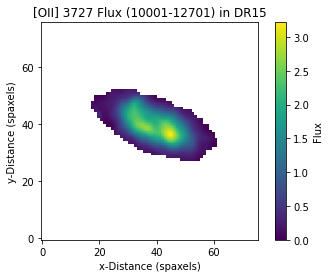

In [10]:
plt.imshow(objmaps_R['OII']['flux'],origin='lower')#,vmin=8.3,vmax=10)
plt.locator_params(axis='y', nbins=5)
plt.title('[OII] 3727 Flux ('+plateifu_R+') in '+version)
plt.xlabel('x-Distance (spaxels)')
plt.ylabel('y-Distance (spaxels)')
plt.colorbar(label='Flux')

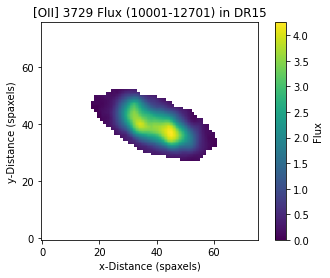

In [11]:
plt.imshow(objmaps_R['OII2']['flux'],origin='lower')#,vmin=8.3,vmax=10)
plt.locator_params(axis='y', nbins=5)
plt.title('[OII] 3729 Flux ('+plateifu_R+') in '+version)
plt.xlabel('x-Distance (spaxels)')
plt.ylabel('y-Distance (spaxels)')
plt.colorbar(label='Flux')